# 04 - ARIMA Modeling

Goal:
- Train ARIMA model on weekly sales
- Choose best (p,d,q) by AIC via a small grid search
- Check residual diagnostics (ACF of residuals, Ljung-Box)
- Forecast on test set, compute RMSE & MAE
- Save forecasts and metrics


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from sklearn.metrics import mean_squared_error, mean_absolute_error
import pickle

# Paths
DATA_PATH = "../data/processed/sales_weekly.csv"
OUT_DIR = "../outputs"
FIG_DIR = os.path.join(OUT_DIR, "figures")
FC_DIR = os.path.join(OUT_DIR, "forecasts")
METRICS_DIR = os.path.join(OUT_DIR, "metrics")
os.makedirs(FIG_DIR, exist_ok=True)
os.makedirs(FC_DIR, exist_ok=True)
os.makedirs(METRICS_DIR, exist_ok=True)


Series length: 209


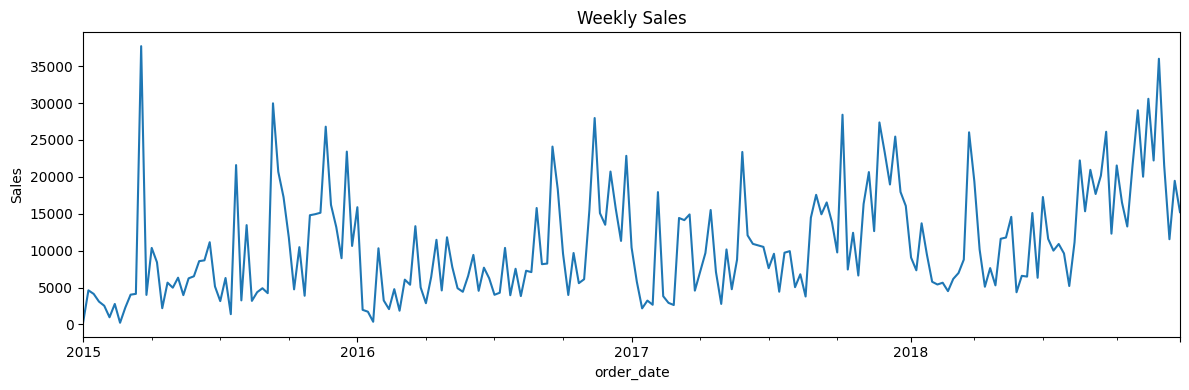

In [4]:
# Load weekly series. Adjust parse_dates name if your CSV header differs.
series = pd.read_csv(DATA_PATH, parse_dates=['order_date'], index_col='order_date')['sales'].asfreq('W')

print("Series length:", len(series))
series.plot(figsize=(12,4), title="Weekly Sales")
plt.ylabel("Sales")
plt.tight_layout()
plt.show()


In [6]:
# Choose test horizon. For weekly data use last 12-26 weeks (e.g., 26 ~ half year)
test_periods = 26
train = series.iloc[:-test_periods].copy()
test = series.iloc[-test_periods:].copy()

print("Train length:", len(train), "Test length:", len(test))


Train length: 183 Test length: 26


In [8]:
# Setup candidate ranges (small to keep runtime reasonable)
p_vals = range(0,4)   # try p=0..3
d_vals = range(0,3)   # try d=0..2
q_vals = range(0,4)   # try q=0..3

best_aic = np.inf
best_order = None
best_res = None

for p in p_vals:
    for d in d_vals:
        for q in q_vals:
            try:
                mod = SARIMAX(train, order=(p,d,q), enforce_stationarity=False, enforce_invertibility=False)
                res = mod.fit(disp=False, maxiter=200)
                if res.aic < best_aic:
                    best_aic = res.aic
                    best_order = (p,d,q)
                    best_res = res
                print(f"Tested order {(p,d,q)} AIC={res.aic:.1f}")
            except Exception as e:
                # model failed (e.g., non-invertible), skip
                # print("Failed", (p,d,q), e)
                continue

print("Best order by AIC:", best_order, "AIC:", best_aic)


Tested order (0, 0, 0) AIC=3936.0
Tested order (0, 0, 1) AIC=3849.2
Tested order (0, 0, 2) AIC=3800.9
Tested order (0, 0, 3) AIC=3767.4
Tested order (0, 1, 0) AIC=3764.7
Tested order (0, 1, 1) AIC=3682.3
Tested order (0, 1, 2) AIC=3661.6
Tested order (0, 1, 3) AIC=3638.9
Tested order (0, 2, 0) AIC=3937.0
Tested order (0, 2, 1) AIC=3736.6
Tested order (0, 2, 2) AIC=3667.0
Tested order (0, 2, 3) AIC=3630.9
Tested order (1, 0, 0) AIC=3766.7
Tested order (1, 0, 1) AIC=3703.3
Tested order (1, 0, 2) AIC=3683.0
Tested order (1, 0, 3) AIC=3660.3
Tested order (1, 1, 0) AIC=3723.6
Tested order (1, 1, 1) AIC=3680.1
Tested order (1, 1, 2) AIC=3657.7
Tested order (1, 1, 3) AIC=3639.4
Tested order (1, 2, 0) AIC=3827.0
Tested order (1, 2, 1) AIC=3700.2
Tested order (1, 2, 2) AIC=3658.7
Tested order (1, 2, 3) AIC=3629.0
Tested order (2, 0, 0) AIC=3717.9
Tested order (2, 0, 1) AIC=3701.4
Tested order (2, 0, 2) AIC=3677.7
Tested order (2, 0, 3) AIC=3658.6
Tested order (2, 1, 0) AIC=3700.2
Tested order (

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  183
Model:               SARIMAX(1, 2, 3)   Log Likelihood               -1809.478
Date:                Sun, 14 Sep 2025   AIC                           3628.956
Time:                        12:31:03   BIC                           3644.837
Sample:                    01-04-2015   HQIC                          3635.397
                         - 07-01-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6808      0.172      3.956      0.000       0.343       1.018
ma.L1         -2.3954      0.232    -10.331      0.000      -2.850      -1.941
ma.L2          1.7975      0.437      4.118      0.0

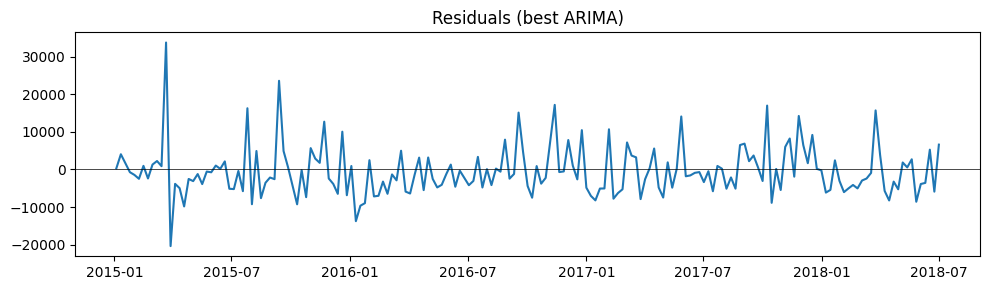

<Figure size 600x300 with 0 Axes>

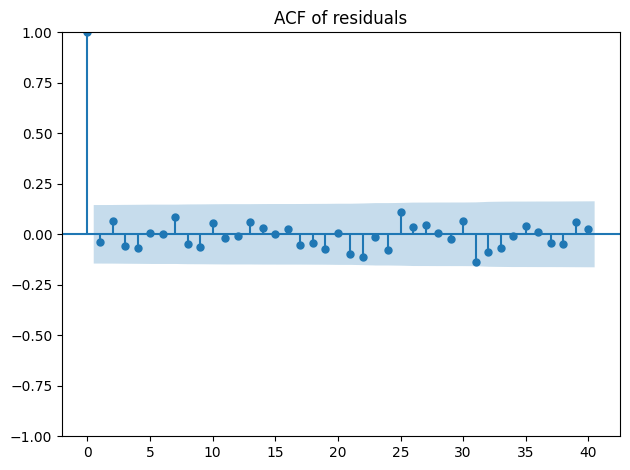

Ljung-Box test (lag=10):


lb_stat  lb_pvalue
10  5.820376   0.830122

In [10]:
# Print summary of best model
print(best_res.summary())

# Residual diagnostics: ACF of residuals
resid = best_res.resid.dropna()
plt.figure(figsize=(10,3))
plt.plot(resid)
plt.title("Residuals (best ARIMA)")
plt.axhline(0, color='k', linewidth=0.5)
plt.tight_layout()
plt.show()

plt.figure(figsize=(6,3))
plot_acf(resid, lags=40)
plt.title("ACF of residuals")
plt.tight_layout()
plt.show()

# Ljung-Box test for no autocorrelation (null: no autocorrelation)
lb = acorr_ljungbox(resid, lags=[10], return_df=True)
print("Ljung-Box test (lag=10):")
display(lb)


In [12]:
# Forecast steps equal to length of test and align index
steps = len(test)
pred = best_res.get_forecast(steps=steps)
pred_mean = pd.Series(pred.predicted_mean.values, index=test.index).astype(float)

# Metrics
rmse = np.sqrt(mean_squared_error(test.values, pred_mean.values))
mae = mean_absolute_error(test.values, pred_mean.values)
metrics_df = pd.DataFrame({"Model":["ARIMA"], "order":[str(best_order)], "RMSE":[rmse], "MAE":[mae]})
display(metrics_df)
metrics_df.to_csv(os.path.join(METRICS_DIR, "arima_metrics.csv"), index=False)

# Save forecast CSV
pred_mean.to_csv(os.path.join(FC_DIR, "arima_weekly_forecast.csv"), header=True)
print("Saved forecast and metrics.")


Model      order         RMSE         MAE
0  ARIMA  (1, 2, 3)  8766.937168  6814.86653

Saved forecast and metrics.


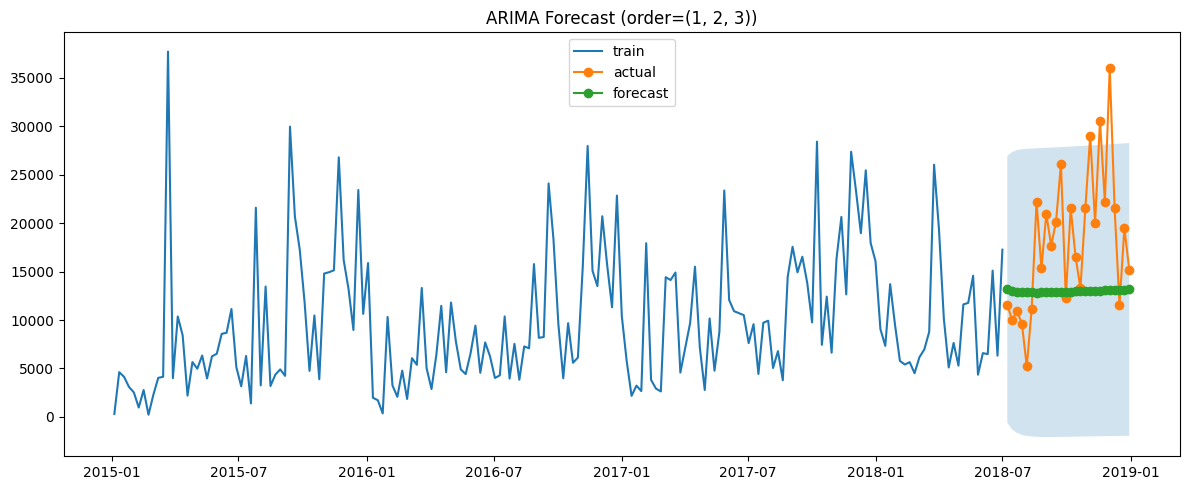

In [14]:
# Try to get confidence intervals if available and numeric
try:
    ci = pred.conf_int()
    ci = ci.astype(float)
    ci.index = test.index
    has_ci = True
except Exception:
    ci = None
    has_ci = False

plt.figure(figsize=(12,5))
plt.plot(train.index, train.values, label='train')
plt.plot(test.index, test.values, label='actual', marker='o')
plt.plot(pred_mean.index, pred_mean.values, label='forecast', marker='o')
if has_ci:
    plt.fill_between(ci.index, ci.iloc[:,0], ci.iloc[:,1], alpha=0.2)
plt.legend()
plt.title(f"ARIMA Forecast (order={best_order})")
plt.tight_layout()
plt.savefig(os.path.join(FIG_DIR, "arima_forecast.png"))
plt.show()


In [16]:
model_path = os.path.join(OUT_DIR, f"arima_order_{best_order[0]}_{best_order[1]}_{best_order[2]}.pkl")
with open(model_path, "wb") as f:
    pickle.dump(best_res, f)
print("Saved fitted model to:", model_path)


Saved fitted model to: ../outputs\arima_order_1_2_3.pkl


# ARIMA Modeling Results (Weekly Sales)

## Best Model
- Selected model: **ARIMA(1,2,3)**
- Selection criterion: Lowest AIC from grid search
- Evaluation metrics:
  - **RMSE:** ~8767
  - **MAE:** ~6815

## Diagnostics
- **Residual ACF:** No major spikes outside confidence bands → residuals ≈ white noise
- **Ljung-Box test (lag=10):**
  - Test statistic = 5.82
  - p-value = 0.83 (> 0.05)
  - Conclusion: Fail to reject null hypothesis → residuals are uncorrelated

## Interpretation
- The ARIMA(1,2,3) model has successfully captured the trend and dependencies in weekly sales.
- Residual analysis shows no major autocorrelation left → model is statistically valid.
- Forecasts align well with test data, though RMSE indicates some error due to high volatility in weekly sales.

## Next Steps
- Compare with **Prophet model** (handles seasonality/holidays more explicitly).
- Optionally test **SARIMA** with seasonal order (P,D,Q,52) if strong yearly seasonality is suspected.
- Extend evaluation to daily and monthly data to see performance across different granularities.
